In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
import datetime
import pickle

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

# 1. Data Pre-processing

## 1.0 Load dataset

In [3]:
df_train = pd.read_csv('dataset/train_yutong.txt')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25718 entries, 0 to 25717
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listing_id          25718 non-null  int64  
 1   name                25718 non-null  object 
 2   street              25718 non-null  object 
 3   type                25718 non-null  object 
 4   bathrooms           24484 non-null  float64
 5   district            25718 non-null  int64  
 6   region              25718 non-null  object 
 7   planning_area       25718 non-null  object 
 8   subszone            25718 non-null  object 
 9   built_year          25645 non-null  float64
 10  no_of_units         24680 non-null  float64
 11  area_size           25718 non-null  float64
 12  date_listed         25718 non-null  object 
 13  price               25718 non-null  float64
 14  bedrooms            25718 non-null  float64
 15  tenure_remains      25718 non-null  int64  
 16  tenu

In [5]:
df_train = df_train.drop(columns=["Unnamed: 0"])

In [7]:
df_train.head()

,listing_id,name,street,type,bathrooms,district,region,planning_area,subszone,built_year,...,shopp_no_3km,secon_min_distance,secon_no_1km,secon_no_3km,prima_min_distance,prima_no_1km,prima_no_3km,train_min_distance,train_no_1km,train_no_3km
0,6998418,seascape,57 cove way,condominium,4.0,4,central region,southern islands,sentosa,2011.0,...,6,2.739930,0,1,2.511796,0,3,2.110841,0,7
1,2046604,la maison,10 moulmein rise,apartment,3.0,11,central region,novena,moulmein,1999.0,...,70,0.786247,3,27,0.145587,7,35,0.230193,5,53
2,7563513,viva,2 suffolk walk,condominium,3.0,11,central region,novena,moulmein,2012.0,...,70,0.668196,1,28,0.182761,7,34,0.331496,5,50
3,3071445,urban treasures,205 jalan eunos,condominium,2.0,14,east region,bedok,kaki bukit,1930.0,...,25,0.308054,1,30,0.300643,4,33,0.426680,5,24
4,9667539,infini at east coast,east coast road,apartment,3.0,15,east region,bedok,frankel,2022.0,...,18,0.388370,3,20,0.232984,6,22,0.822432,2,18


In [8]:
df_train.describe()

,listing_id,bathrooms,district,built_year,no_of_units,area_size,price,bedrooms,tenure_remains,tenure_years,...,shopp_no_3km,secon_min_distance,secon_no_1km,secon_no_3km,prima_min_distance,prima_no_1km,prima_no_3km,train_min_distance,train_no_1km,train_no_3km
count,2.571800e+04,24484.000000,25718.000000,25645.000000,24680.000000,25718.000000,2.571800e+04,25718.000000,25718.000000,25718.000000,...,25718.000000,25718.000000,25718.000000,25718.000000,25718.000000,25718.000000,25718.000000,25718.000000,25718.000000,25718.000000
mean,5.495814e+06,2.281000,12.212497,1995.159524,461.681483,1251.166343,3.003332e+06,2.566879,380276.113889,456.263395,...,41.989579,0.605690,2.800451,19.775138,0.481503,3.754024,25.373318,0.410230,4.955984,31.333541
std,2.607456e+06,1.146691,7.011785,33.875646,423.024212,1067.453284,4.340523e+06,1.143536,485386.342802,440.349250,...,24.588214,0.414985,2.118362,7.724840,0.340616,2.441141,9.615606,0.328124,3.867986,13.351714
min,1.000122e+06,1.000000,1.000000,1910.000000,4.000000,323.000000,5.566000e+05,0.000000,0.000000,99.000000,...,4.000000,0.014425,0.000000,1.000000,0.008718,0.000000,3.000000,0.000051,0.000000,4.000000
25%,3.227969e+06,1.000000,7.000000,1985.000000,130.000000,689.000000,1.342000e+06,2.000000,99.000000,99.000000,...,18.000000,0.319962,1.000000,15.000000,0.270678,2.000000,19.000000,0.178788,2.000000,20.000000
50%,5.489918e+06,2.000000,11.000000,2013.000000,366.000000,958.000000,1.856800e+06,3.000000,99.000000,99.000000,...,38.000000,0.522009,3.000000,20.000000,0.401050,3.000000,25.000000,0.332035,4.000000,34.000000
75%,7.764957e+06,3.000000,18.000000,2017.000000,646.000000,1363.750000,2.956800e+06,3.000000,1000000.000000,999.000000,...,70.000000,0.773172,4.000000,25.000000,0.605686,5.000000,31.000000,0.534392,7.000000,44.000000
max,9.999807e+06,8.000000,28.000000,2029.000000,2203.000000,15000.000000,7.480000e+07,8.000000,1000000.000000,999.000000,...,82.000000,2.739930,9.000000,40.000000,2.511796,14.000000,50.000000,2.110841,20.000000,55.000000


###  (optional) drop meaningless attributes

In [9]:
meaningless_attrs = ['tenure_remains', 'listing_id', 'date_listed','street','name'
                    ,'planning_area','subszone']
# meaningless_attrs = ['tenure_remains', 'date_listed', 'street', 'listing_id']

df_train_small = df_train.drop(labels=meaningless_attrs, axis=1)

In [10]:
df_train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25718 entries, 0 to 25717
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                25718 non-null  object 
 1   bathrooms           24484 non-null  float64
 2   district            25718 non-null  int64  
 3   region              25718 non-null  object 
 4   built_year          25645 non-null  float64
 5   no_of_units         24680 non-null  float64
 6   area_size           25718 non-null  float64
 7   price               25718 non-null  float64
 8   bedrooms            25718 non-null  float64
 9   tenure_years        25718 non-null  int64  
 10  comme_min_distance  25718 non-null  float64
 11  comme_no_1km        25718 non-null  int64  
 12  comme_no_3km        25718 non-null  int64  
 13  gov-m_min_distance  25718 non-null  float64
 14  gov-m_no_1km        25718 non-null  int64  
 15  gov-m_no_3km        25718 non-null  int64  
 16  shop

## 1.1 Label encoding

There are multiple ways to encode the categorical values.

We explore:
 a) ordered encoding
 b) one-hot encoding
 c) combination of a) and b)

In [11]:
df_train_small.dtypes

type                   object
bathrooms             float64
district                int64
region                 object
built_year            float64
no_of_units           float64
area_size             float64
price                 float64
bedrooms              float64
tenure_years            int64
comme_min_distance    float64
comme_no_1km            int64
comme_no_3km            int64
gov-m_min_distance    float64
gov-m_no_1km            int64
gov-m_no_3km            int64
shopp_min_distance    float64
shopp_no_1km            int64
shopp_no_3km            int64
secon_min_distance    float64
secon_no_1km            int64
secon_no_3km            int64
prima_min_distance    float64
prima_no_1km            int64
prima_no_3km            int64
train_min_distance    float64
train_no_1km            int64
train_no_3km            int64
dtype: object

In [ ]:
# df_train_small.date_listed = pd.to_datetime(df_train_small.date_listed)

In [13]:
df_train_small.head()

,type,bathrooms,district,region,built_year,no_of_units,area_size,price,bedrooms,tenure_years,...,shopp_no_3km,secon_min_distance,secon_no_1km,secon_no_3km,prima_min_distance,prima_no_1km,prima_no_3km,train_min_distance,train_no_1km,train_no_3km
0,condominium,4.0,4,central region,2011.0,151.0,2336.0,5390000.0,3.0,99,...,6,2.739930,0,1,2.511796,0,3,2.110841,0,7
1,apartment,3.0,11,central region,1999.0,24.0,1259.0,2310000.0,3.0,999,...,70,0.786247,3,27,0.145587,7,35,0.230193,5,53
2,condominium,3.0,11,central region,2012.0,235.0,1959.0,5279500.0,4.0,999,...,70,0.668196,1,28,0.182761,7,34,0.331496,5,50
3,condominium,2.0,14,east region,1930.0,237.0,883.0,1843600.0,3.0,999,...,25,0.308054,1,30,0.300643,4,33,0.426680,5,24
4,apartment,3.0,15,east region,2022.0,36.0,1066.0,2262700.0,3.0,999,...,18,0.388370,3,20,0.232984,6,22,0.822432,2,18


In [14]:
df_train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25718 entries, 0 to 25717
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                25718 non-null  object 
 1   bathrooms           24484 non-null  float64
 2   district            25718 non-null  int64  
 3   region              25718 non-null  object 
 4   built_year          25645 non-null  float64
 5   no_of_units         24680 non-null  float64
 6   area_size           25718 non-null  float64
 7   price               25718 non-null  float64
 8   bedrooms            25718 non-null  float64
 9   tenure_years        25718 non-null  int64  
 10  comme_min_distance  25718 non-null  float64
 11  comme_no_1km        25718 non-null  int64  
 12  comme_no_3km        25718 non-null  int64  
 13  gov-m_min_distance  25718 non-null  float64
 14  gov-m_no_1km        25718 non-null  int64  
 15  gov-m_no_3km        25718 non-null  int64  
 16  shop

In [15]:
df_train_ord = df_train_small.copy()

### 1.1.A. Ordinal encoding

> Note: the key here is to create an encoder for each individual categorical value

In [12]:
df_train_small.columns[df_train_small.dtypes==object]


Index(['type', 'region'], dtype='object')

In [71]:
ord_enc = OrdinalEncoder()

cat_cols = ['name', 'type', 'region', 'planning_area', 'subszone']
encoders = {k:OrdinalEncoder() for k in cat_cols }
for cate in cat_cols:
    df_train_ord[f"{cate}_code"] = encoders[cate].fit_transform(df_train_ord[[cate]])
df_train_ord.head(11)

,name,street,type,bathrooms,district,region,planning_area,subszone,built_year,no_of_units,area_size,price,bedrooms,tenure_years,name_code,type_code,region_code,planning_area_code,subszone_code
0,seascape,57 cove way,condominium,4.0,4,central region,southern islands,sentosa,2011.0,151.0,2336.0,5390000.0,3.0,99,1059.0,1.0,0.0,32.0,147.0
1,la maison,10 moulmein rise,apartment,3.0,11,central region,novena,moulmein,1999.0,24.0,1259.0,2310000.0,3.0,999,617.0,0.0,0.0,20.0,108.0
2,viva,2 suffolk walk,condominium,3.0,11,central region,novena,moulmein,2012.0,235.0,1959.0,5279500.0,4.0,999,1582.0,1.0,0.0,20.0,108.0
3,urban treasures,205 jalan eunos,condominium,2.0,14,east region,bedok,kaki bukit,1930.0,237.0,883.0,1843600.0,3.0,999,1550.0,1.0,1.0,1.0,76.0
4,infini at east coast,east coast road,apartment,3.0,15,east region,bedok,frankel,2022.0,36.0,1066.0,2262700.0,3.0,999,530.0,0.0,1.0,1.0,56.0
5,the watergardens at canberra,canberra drive,apartment,1.0,27,north region,sembawang,sembawang springs,1930.0,448.0,678.0,1131900.0,2.0,99,1480.0,0.0,2.0,28.0,143.0
6,midwood,hillview rise,condominium,3.0,23,west region,bukit batok,hillview,1930.0,564.0,1249.0,2189000.0,4.0,99,736.0,1.0,4.0,3.0,62.0
7,sengkang grand residences,compassvale bow,apartment,2.0,19,north-east region,sengkang,compassvale,2023.0,680.0,936.0,1595000.0,3.0,99,1068.0,0.0,3.0,29.0,41.0
8,midtown bay,122 beach road,apartment,1.0,7,central region,downtown core,city hall,2021.0,219.0,409.0,1490500.0,1.0,99,733.0,0.0,0.0,10.0,36.0
9,76 shenton,76 shenton way,apartment,1.0,2,central region,downtown core,anson,2014.0,202.0,592.0,1265000.0,1.0,99,26.0,0.0,0.0,10.0,5.0


Drop original columns and check value

In [72]:
df_train_ord = df_train_ord.drop(columns=cat_cols, axis=1)
df_train_ord = df_train_ord.drop(columns='street', axis=1)

In [73]:
df_train_ord.head()

,bathrooms,district,built_year,no_of_units,area_size,price,bedrooms,tenure_years,name_code,type_code,region_code,planning_area_code,subszone_code
0,4.0,4,2011.0,151.0,2336.0,5390000.0,3.0,99,1059.0,1.0,0.0,32.0,147.0
1,3.0,11,1999.0,24.0,1259.0,2310000.0,3.0,999,617.0,0.0,0.0,20.0,108.0
2,3.0,11,2012.0,235.0,1959.0,5279500.0,4.0,999,1582.0,1.0,0.0,20.0,108.0
3,2.0,14,1930.0,237.0,883.0,1843600.0,3.0,999,1550.0,1.0,1.0,1.0,76.0
4,3.0,15,2022.0,36.0,1066.0,2262700.0,3.0,999,530.0,0.0,1.0,1.0,56.0


In [58]:
# for cate in cat_cols:
#     df_train_small[cate] = df_train_small[cate].astype('category')
# df_train_small.info()

### 1.1.B One-hot Encoder

In [34]:
df_train_oh = df_train_small.copy()


In [35]:
df_train_oh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25718 entries, 0 to 25717
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                25718 non-null  object 
 1   bathrooms           24484 non-null  float64
 2   district            25718 non-null  int64  
 3   region              25718 non-null  object 
 4   built_year          25645 non-null  float64
 5   no_of_units         24680 non-null  float64
 6   area_size           25718 non-null  float64
 7   price               25718 non-null  float64
 8   bedrooms            25718 non-null  float64
 9   tenure_years        25718 non-null  int64  
 10  comme_min_distance  25718 non-null  float64
 11  comme_no_1km        25718 non-null  int64  
 12  comme_no_3km        25718 non-null  int64  
 13  gov-m_min_distance  25718 non-null  float64
 14  gov-m_no_1km        25718 non-null  int64  
 15  gov-m_no_3km        25718 non-null  int64  
 16  shop

In [36]:
cat_cols = [ 'type', 'region', 'district','tenure_years']

for i in range(len(cat_cols)):
    df_train_oh = pd.merge(df_train_oh, pd.get_dummies(df_train_oh[cat_cols[i]], prefix=cat_cols[i]), on=df_train_oh.index.values)
    df_train_oh.drop(columns=['key_0', cat_cols[i]], inplace=True)

In [37]:
df_train_oh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25718 entries, 0 to 25717
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bathrooms                 24484 non-null  float64
 1   built_year                25645 non-null  float64
 2   no_of_units               24680 non-null  float64
 3   area_size                 25718 non-null  float64
 4   price                     25718 non-null  float64
 5   bedrooms                  25718 non-null  float64
 6   comme_min_distance        25718 non-null  float64
 7   comme_no_1km              25718 non-null  int64  
 8   comme_no_3km              25718 non-null  int64  
 9   gov-m_min_distance        25718 non-null  float64
 10  gov-m_no_1km              25718 non-null  int64  
 11  gov-m_no_3km              25718 non-null  int64  
 12  shopp_min_distance        25718 non-null  float64
 13  shopp_no_1km              25718 non-null  int64  
 14  shopp_

In [38]:
df_train_oh.head()

,bathrooms,built_year,no_of_units,area_size,price,bedrooms,comme_min_distance,comme_no_1km,comme_no_3km,gov-m_min_distance,...,district_20,district_21,district_22,district_23,district_25,district_26,district_27,district_28,tenure_years_99,tenure_years_999
0,4.0,2011.0,151.0,2336.0,5390000.0,3.0,3.465477,0,0,2.523949,...,0,0,0,0,0,0,0,0,1,0
1,3.0,1999.0,24.0,1259.0,2310000.0,3.0,0.253532,2,6,0.322039,...,0,0,0,0,0,0,0,0,0,1
2,3.0,2012.0,235.0,1959.0,5279500.0,4.0,0.308259,1,5,0.402367,...,0,0,0,0,0,0,0,0,0,1
3,2.0,1930.0,237.0,883.0,1843600.0,3.0,1.146688,0,3,0.632724,...,0,0,0,0,0,0,0,0,0,1
4,3.0,2022.0,36.0,1066.0,2262700.0,3.0,1.380337,0,1,0.384105,...,0,0,0,0,0,0,0,0,0,1


### 1.1.C Combine ordered and one-hot

In [ ]:
# one-hot encode the categorical features

full_pipeline = ColumnTransformer([('cat', OrdinalEncoder(handle_unknown=''), cat_cols)],
                                  remainder='passthrough')

encoder = full_pipeline.fit(train_X)
train_X_cleaned = encoder.transform(train_X)
# X_test = encoder.transform(X_test)

In [ ]:
oh_encoder = OneHotEncoder()
oh_encoder.fit(train_X)
train_X_cleaned = oh_encoder.transform(train_X).toarray()
oh_encoder.categories_

In [ ]:
train_X_cleaned.shape

## 1.2 Fill nan values

In [39]:
print(df_train_oh.isnull().sum().sort_values(ascending = False).head(5))


bathrooms             1234
no_of_units           1038
built_year              73
secon_min_distance       0
region_east region       0
dtype: int64


In [46]:
mean_cols = df_train_oh.mean()
train_data = df_train_oh.fillna(mean_cols)

print(train_data.isnull().sum().sum())

0


## 1.3 Normalization

In [47]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25718 entries, 0 to 25717
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bathrooms                 25718 non-null  float64
 1   built_year                25718 non-null  float64
 2   no_of_units               25718 non-null  float64
 3   area_size                 25718 non-null  float64
 4   price                     25718 non-null  float64
 5   bedrooms                  25718 non-null  float64
 6   comme_min_distance        25718 non-null  float64
 7   comme_no_1km              25718 non-null  int64  
 8   comme_no_3km              25718 non-null  int64  
 9   gov-m_min_distance        25718 non-null  float64
 10  gov-m_no_1km              25718 non-null  int64  
 11  gov-m_no_3km              25718 non-null  int64  
 12  shopp_min_distance        25718 non-null  float64
 13  shopp_no_1km              25718 non-null  int64  
 14  shopp_

In [42]:
train_data.head()

,bathrooms,built_year,no_of_units,area_size,price,bedrooms,comme_min_distance,comme_no_1km,comme_no_3km,gov-m_min_distance,...,district_20,district_21,district_22,district_23,district_25,district_26,district_27,district_28,tenure_years_99,tenure_years_999
0,4.0,2011.0,151.0,2336.0,5390000.0,3.0,3.465477,0,0,2.523949,...,0,0,0,0,0,0,0,0,1,0
1,3.0,1999.0,24.0,1259.0,2310000.0,3.0,0.253532,2,6,0.322039,...,0,0,0,0,0,0,0,0,0,1
2,3.0,2012.0,235.0,1959.0,5279500.0,4.0,0.308259,1,5,0.402367,...,0,0,0,0,0,0,0,0,0,1
3,2.0,1930.0,237.0,883.0,1843600.0,3.0,1.146688,0,3,0.632724,...,0,0,0,0,0,0,0,0,0,1
4,3.0,2022.0,36.0,1066.0,2262700.0,3.0,1.380337,0,1,0.384105,...,0,0,0,0,0,0,0,0,0,1


In [50]:
standard_vars = ['bathrooms', 'built_year', 'no_of_units', 'area_size','bedrooms', 'comme_min_distance','comme_no_1km', 'comme_no_3km',
       'gov-m_min_distance', 'gov-m_no_1km', 'gov-m_no_3km',
       'shopp_min_distance', 'shopp_no_1km', 'shopp_no_3km',
       'secon_min_distance', 'secon_no_1km', 'secon_no_3km',
       'prima_min_distance', 'prima_no_1km', 'prima_no_3km',
       'train_min_distance', 'train_no_1km', 'train_no_3km']

non_standard_vars = ['type_apartment',
       'type_condominium', 'region_central region', 'region_east region',
       'region_north region', 'region_north-east region', 'region_west region',
       'district_1', 'district_2', 'district_3', 'district_4', 'district_5',
       'district_6', 'district_7', 'district_8', 'district_9', 'district_10',
       'district_11', 'district_12', 'district_13', 'district_14',
       'district_15', 'district_16', 'district_17', 'district_18',
       'district_19', 'district_20', 'district_21', 'district_22',
       'district_23', 'district_25', 'district_26', 'district_27',
       'district_28', 'tenure_years_99', 'tenure_years_999']

df_stand_part = pd.DataFrame(StandardScaler().fit_transform(train_data[standard_vars]), columns=standard_vars,
                            index=train_data.index)
df_train_stand = pd.concat([train_data[non_standard_vars], df_stand_part], axis=1)

In [51]:
df_train_stand

,type_apartment,type_condominium,region_central region,region_east region,region_north region,region_north-east region,region_west region,district_1,district_2,district_3,...,shopp_no_3km,secon_min_distance,secon_no_1km,secon_no_3km,prima_min_distance,prima_no_1km,prima_no_3km,train_min_distance,train_no_1km,train_no_3km
0,0,1,1,0,0,0,0,0,0,0,...,-1.463721,5.143039,-1.322015,-2.430536,5.960762,-1.537845,-2.326817,5.182931,-1.281308,-1.822539
1,1,0,1,0,0,0,0,0,0,0,...,1.139203,0.435103,0.094201,0.935295,-0.986220,1.329722,1.001171,-0.548697,0.011380,1.622779
2,0,1,1,0,0,0,0,0,0,0,...,1.139203,0.150626,-0.849943,1.064750,-0.877082,1.329722,0.897172,-0.239956,0.011380,1.398084
3,0,1,0,1,0,0,0,0,0,0,...,-0.690978,-0.717235,-0.849943,1.323660,-0.530989,0.100765,0.793172,0.050133,0.011380,-0.549269
4,1,0,0,1,0,0,0,0,0,0,...,-0.975673,-0.523691,0.094201,0.029110,-0.729630,0.920069,-0.350824,1.256263,-0.764233,-0.998658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25713,0,1,1,0,0,0,0,0,0,0,...,1.220544,-0.757625,0.566274,-0.359256,-0.829750,0.100765,-0.454823,0.160414,-0.505695,1.023593
25714,0,1,1,0,0,0,0,0,0,0,...,1.017191,-0.544238,0.094201,0.676385,-0.298463,-0.718540,0.585173,-0.434884,-0.247158,0.873797
25715,0,1,0,1,0,0,0,0,0,0,...,-1.057014,-1.312238,1.038346,0.288020,-1.044133,0.920069,0.585173,-0.852611,-0.505695,-1.448048
25716,0,1,0,0,0,0,1,0,0,0,...,-0.935002,-0.517946,0.094201,0.805840,-0.188764,-0.308888,-0.142825,-0.745817,-0.764233,-1.373149


# 2. XGBoost Model Training

In [52]:
train_data = df_train_stand.copy()
# train_data = df_train_small.copy()
# train_data = df_train.copy()

In [55]:
"price" in df_train_oh.columns

True

In [57]:
train_X = train_data
train_y = df_train_oh.price

In [60]:
train_X.shape

(25718, 59)

In [61]:
train_y.shape

(25718,)

In [62]:
train_X.head()

,type_apartment,type_condominium,region_central region,region_east region,region_north region,region_north-east region,region_west region,district_1,district_2,district_3,...,shopp_no_3km,secon_min_distance,secon_no_1km,secon_no_3km,prima_min_distance,prima_no_1km,prima_no_3km,train_min_distance,train_no_1km,train_no_3km
0,0,1,1,0,0,0,0,0,0,0,...,-1.463721,5.143039,-1.322015,-2.430536,5.960762,-1.537845,-2.326817,5.182931,-1.281308,-1.822539
1,1,0,1,0,0,0,0,0,0,0,...,1.139203,0.435103,0.094201,0.935295,-0.986220,1.329722,1.001171,-0.548697,0.011380,1.622779
2,0,1,1,0,0,0,0,0,0,0,...,1.139203,0.150626,-0.849943,1.064750,-0.877082,1.329722,0.897172,-0.239956,0.011380,1.398084
3,0,1,0,1,0,0,0,0,0,0,...,-0.690978,-0.717235,-0.849943,1.323660,-0.530989,0.100765,0.793172,0.050133,0.011380,-0.549269
4,1,0,0,1,0,0,0,0,0,0,...,-0.975673,-0.523691,0.094201,0.029110,-0.729630,0.920069,-0.350824,1.256263,-0.764233,-0.998658


In [63]:
train_y.head()

0    5390000.0
1    2310000.0
2    5279500.0
3    1843600.0
4    2262700.0
Name: price, dtype: float64

Use XGBoost's optimized data structure

In [64]:
# train_X = train_X.drop('date_listed', axis=1)
data_dmatrix = xgb.DMatrix(data=train_X,label=train_y)

## 2.1 Split cross-validation set

In [105]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

## 2.2 Train a single XGBoost Regressor

In [66]:
xg_reg = xgb.XGBRegressor(eval_metric='rmse',
                          seed=42,
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          n_jobs=2,
                          max_depth = 5,
                          alpha = 10,
                          n_estimators = 10)

In [67]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

## 2.3 Training evaluation

In [69]:
# grid search version
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 2866892.548677


In [70]:
params = {'eval_metric':'rmse','colsample_bytree': 0.3,'learning_rate': 0.01,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50,early_stopping_rounds=15,
                    metrics="rmse", as_pandas=True, seed=42)

[14:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[14:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[14:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[14:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[14:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[14:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[14:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[14:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[14:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 p

In [71]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5245446.70,41856.094533,5232877.10,372621.219443
1,5211237.85,39664.111822,5200309.90,374894.674197
2,5170990.20,40223.553397,5160582.60,373680.005140
3,5133708.15,37461.253932,5123866.25,376468.573701
4,5093133.30,34946.312344,5084738.65,378165.467104


In [72]:
print((cv_results["test-rmse-mean"]).tail(1))

49    3684979.8
Name: test-rmse-mean, dtype: float64


## 2.4 Hyper-parameter Optimization

### 2.4.1 Grid search

In [191]:
%%time
# Various hyper-parameters to tune
gbt_reg = xgb.XGBRegressor(eval_metric='rmse', seed=42,)
parameters = {'learning_rate': np.arange(0.07, 0.15, 0.02), #so called `eta` value
              'max_depth': np.arange(8,14,2),
              'gamma': np.arange (6,10, 2),
              # 'reg_alpha' :  np.arange(140,180,10),
              # 'min_child_weight': np.arange(6,10,1),
              'colsample_bytree': np.arange(0.9, 1.05, 0.05),
              'n_estimators': [100, 150, 200]}

xgb_grid = GridSearchCV(gbt_reg,
                        parameters,
                        cv = 5,
                        verbose=True)

xgb_grid.fit(train_X,train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/Users/shiziji/miniconda/envs/CS5228/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shiziji/miniconda/envs/CS5228/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shiziji/miniconda/envs/CS5228/lib/python3.6/site-packages/xgboost/sklearn.py", line 324, in fit
    verbose_eval=verbose, xgb_model=xgb_model)
  File "/Users/shiziji/miniconda/envs/CS5228/lib/python3.6/site-packages/xgboost/training.py", line 204, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/Users/shiziji/miniconda/envs/CS5228/lib/python3.6/site-packages/xgboost/training.py", line 74, in _train_internal
    bst.update(dtrain, i, obj)
  File "/Users/shiziji/miniconda/envs/CS5228/lib/python3.6/sit

0.9649455882746096
{'colsample_bytree': 0.9500000000000001, 'gamma': 6, 'learning_rate': 0.13, 'max_depth': 10, 'n_estimators': 150}
CPU times: user 3h 34min 25s, sys: 2min 9s, total: 3h 36min 34s
Wall time: 3h 43min 57s


### 2.4.2 Bayesian Optimization

In [75]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [161]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'gamma': hp.quniform ('gamma', 1,9,1),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 10,300,1),
        'seed': 42
    }

In [169]:
def objective(space):
    regressor=xgb.XGBRegressor(eval_metric='rmse',
                               learning_rate=space['learning_rate'],
                               gamma = int(space['gamma']),
                               n_estimators =int(space['n_estimators']),
                               max_depth = int(space['max_depth']),
                               reg_alpha = int(space['reg_alpha']),
                               reg_lambda=space['reg_lambda'],
                               min_child_weight=int(space['min_child_weight']),
                               colsample_bytree=space['colsample_bytree'])
    X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
    evaluation = [( X_train, y_train), ( X_test, y_test)]

    regressor.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


    pred = regressor.predict(X_test)
    rmse = mean_squared_error(y_test, pred)
    # print ("RMSE:", rmse)
    return {'loss': rmse, 'status': STATUS_OK }

In [172]:
%%time
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 3000,
                        trials = trials)

100%|██████████| 3000/3000 [4:44:10<00:00,  5.68s/trial, best loss: 319053299299.66974]  
CPU times: user 4h 36min 44s, sys: 2min 19s, total: 4h 39min 4s
Wall time: 4h 44min 10s


In [173]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)


The best hyperparameters are :  

{'colsample_bytree': 0.9816822002582682, 'gamma': 9.0, 'learning_rate': 0.11222077300548614, 'max_depth': 11.0, 'min_child_weight': 4.0, 'n_estimators': 85.0, 'reg_alpha': 123.0, 'reg_lambda': 0.04504339981540094}


In [174]:
bo_best_params = {'colsample_bytree': 0.9816822002582682, 'gamma': 9,'learning_rate': 0.11, 'max_depth': 11, 'n_estimators': 85.0, 'min_child_weight': 4, 'reg_alpha': 123, 'reg_lambda': 0.045}

In [175]:
%%time

best_bo_reg = xgb.XGBRegressor(eval_metric='rmse',
                               learning_rate=0.11,
                                n_estimators =85,
                               max_depth = 11, gamma = 9,
                                reg_alpha = 123,
                               min_child_weight=4,
                               reg_lambda=0.045,
                                colsample_bytree=0.98)
best_bo_reg.fit(X_train, y_train)
preds = best_bo_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 600748.105357
CPU times: user 8.19 s, sys: 208 ms, total: 8.39 s
Wall time: 9.15 s


## 2.5 Save trained model using pickle

Save the model object in pickle format

In [176]:
import pickle

with open('model/xgb_tree/xgb_bo_apr9.pickle', 'wb') as handle:
    pickle.dump(best_bo_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

Load the pickle object

In [ ]:
with open('model/xgb_tree/xgb_mar27.pickle', 'rb') as handle:
    b = pickle.load(handle)

# print(best_reg == b)

## 2.6 Visualize learned decision tree

ValueError: Unable to parse node: 101:[region_central

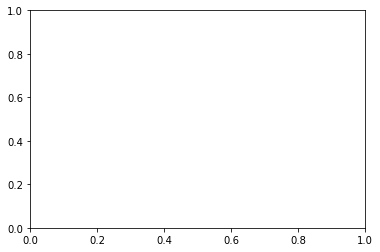

In [177]:

xgb.plot_tree(best_bo_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.plot()
plt.savefig('plots/xgb_tree/bo_tree_vis.pdf', format='pdf', dpi=1200)

### Plot the importance of features

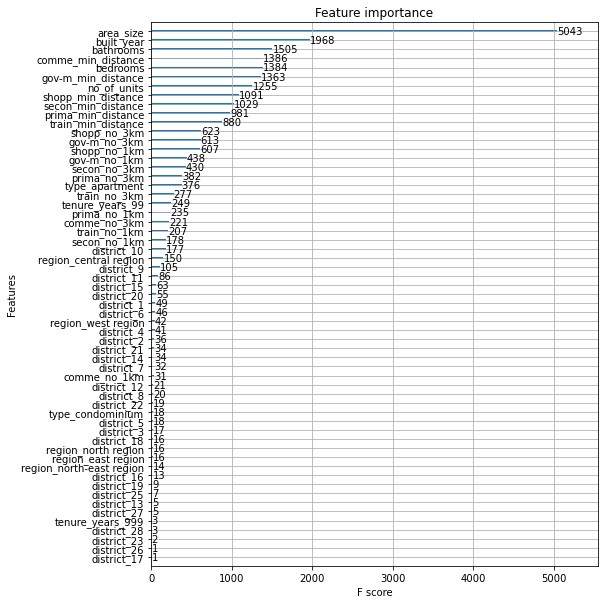

In [182]:
def my_plot_importance(booster, figsize, **kwargs):
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
my_plot_importance(best_bo_reg, [8,10])
plt.savefig('plots/xgb_tree/bo_feature_importance.pdf', format='pdf', dpi=1200)

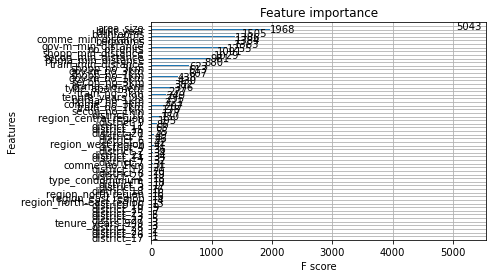

In [180]:
xgb.plot_importance(best_bo_reg)
plt.rcParams['figure.figsize'] = [5, 5]
# plt.show()
plt.savefig('plots/xgb_tree/bo_feature_importance.pdf', format='pdf', dpi=1200)

# 3. XGBoost Model Inference

In [189]:
test_df = pd.read_csv('dataset/test_yutong.txt')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          7500 non-null   int64  
 1   listing_id          7500 non-null   int64  
 2   name                7500 non-null   object 
 3   street              7500 non-null   object 
 4   type                7500 non-null   object 
 5   bathrooms           7163 non-null   float64
 6   district            7500 non-null   int64  
 7   region              7500 non-null   object 
 8   planning_area       7500 non-null   object 
 9   subszone            7500 non-null   object 
 10  built_year          7452 non-null   float64
 11  no_of_units         7174 non-null   float64
 12  area_size           7500 non-null   float64
 13  date_listed         7500 non-null   object 
 14  bedrooms            7500 non-null   int64  
 15  tenure_remains      7500 non-null   int64  
 16  tenure

In [134]:
# drop attr
df_test=test_df.copy()
df_test = df_test.drop(labels=meaningless_attrs, axis=1)

In [135]:
# one-hot encoding
for i in range(len(cat_cols)):
    df_test = pd.merge(df_test, pd.get_dummies(df_test[cat_cols[i]], prefix=cat_cols[i]), on=df_test.index.values)
    df_test.drop(columns=['key_0', cat_cols[i]], inplace=True)

# # int to float
# df_test=df_test.astype(float)



In [190]:
def check_missing_values(df):
    print("Stats for missing values:")
    print("-"*15)
    for col in df:
        print(f"{col}: ", df[col].isna().sum())
check_missing_values(test_df)

Stats for missing values:
---------------
Unnamed: 0:  0
listing_id:  0
name:  0
street:  0
type:  0
bathrooms:  337
district:  0
region:  0
planning_area:  0
subszone:  0
built_year:  48
no_of_units:  326
area_size:  0
date_listed:  0
bedrooms:  0
tenure_remains:  0
tenure_years:  0
comme_min_distance:  0
comme_no_1km:  0
comme_no_3km:  0
gov-m_min_distance:  0
gov-m_no_1km:  0
gov-m_no_3km:  0
shopp_min_distance:  0
shopp_no_1km:  0
shopp_no_3km:  0
secon_min_distance:  0
secon_no_1km:  0
secon_no_3km:  0
prima_min_distance:  0
prima_no_1km:  0
prima_no_3km:  0
train_min_distance:  0
train_no_1km:  0
train_no_3km:  0


Fill nan by mean value

In [ ]:
# fill nan
mean_cols = df_test.mean()
df_test = df_test.fillna(mean_cols)


df_stand_part = pd.DataFrame(StandardScaler().fit_transform(df_test[standard_vars]), columns=standard_vars,index=df_test.index)
df_test = pd.concat([df_test[non_standard_vars], df_stand_part], axis=1)

Alternatively, fill nan by lookup table

In [141]:
test_X = df_test.values
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 59 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   type_apartment            7500 non-null   uint8  
 1   type_condominium          7500 non-null   uint8  
 2   region_central region     7500 non-null   uint8  
 3   region_east region        7500 non-null   uint8  
 4   region_north region       7500 non-null   uint8  
 5   region_north-east region  7500 non-null   uint8  
 6   region_west region        7500 non-null   uint8  
 7   district_1                7500 non-null   uint8  
 8   district_2                7500 non-null   uint8  
 9   district_3                7500 non-null   uint8  
 10  district_4                7500 non-null   uint8  
 11  district_5                7500 non-null   uint8  
 12  district_6                7500 non-null   uint8  
 13  district_7                7500 non-null   uint8  
 14  district

In [137]:
train_data.shape

(25718, 59)

In [138]:
df_test.columns == train_data.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [183]:
test_pred = best_bo_reg.predict(df_test)

In [184]:
df_submission = pd.DataFrame()
df_submission["Id"] = test_df.index
df_submission["Predicted"] = test_pred
df_submission

,Id,Predicted
0,0,1.920238e+06
1,1,2.592432e+06
2,2,7.285326e+05
3,3,9.602443e+05
4,4,2.108458e+07
...,...,...
7495,7495,1.320475e+06
7496,7496,2.020566e+06
7497,7497,1.606853e+06
7498,7498,9.551532e+05


In [185]:
df_submission.to_csv("xgb_bo_apr9.csv", index=False)